<a href="https://colab.research.google.com/github/user77772772/models/blob/main/Mnist_cnn_model_withpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Convert MNIST image files into a tensor of 4-dimensions(no of img,height,width,color)
transform=transforms.ToTensor()

In [7]:
# Train & Test Data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 35.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 981kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.95MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.70MB/s]


In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
# Create batch size  for images
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [10]:
for i, (x_train, y_train) in enumerate(train_data):
  break

In [14]:
x_train.shape

torch.Size([1, 28, 28])

In [17]:
x=x_train.view(1,1,28,28)

In [18]:
x.shape

torch.Size([1, 1, 28, 28])

In [11]:
# Model Class
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully Connected Layer
    self.fcl1 = nn.Linear(16*5*5, 120)
    self.fcl2 = nn.Linear(120, 84)
    self.fcl3 = nn.Linear(84, 10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and 2 stride

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-view to flatten it out
    X = X.view(-1, 16*5*5) # -ve 1 so that we can vary batch size

    # Fully Connected Layers
    X = F.relu(self.fcl1(X))
    X = F.relu(self.fcl2(X))
    X = self.fcl3(X) # No relu on last layer

    return F.log_softmax(X, dim=1)


In [12]:
# Create instance of our model
torch.manual_seed(42)
model = CNNModel()
model

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fcl1): Linear(in_features=400, out_features=120, bias=True)
  (fcl2): Linear(in_features=120, out_features=84, bias=True)
  (fcl3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
# Training & Testing Part

# Create Variable to track things
epochs = 5
train_loss = []
test_loss = []
train_correct = []
test_correct = []

# For loop of epochs
for epoch in range(epochs):
  trn_corr = 0
  tst_corr= 0

# Train
  for b,(x_train, y_train) in enumerate(train_loader):
    b += 1 # Start our batches at 1
    y_pred = model(x_train)
    loss = criterion(y_pred,y_train)
    predicted = torch.max(y_pred ,1)[1]
    batch_corr = (predicted==y_train).sum()
    trn_corr += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print some results
    if b%600 == 0:
      print(f'Epoch: {epoch},batch: {b} Loss: {loss.item()}')

  train_loss.append(loss)
  train_correct.append(trn_corr)

# Test
  with torch.no_grad():
    for b,(x_test, y_test) in enumerate(test_loader):
      y_val = model(x_test)
      predicted = torch.max(y_val, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val ,y_test)
  test_loss.append(loss)
  test_correct.append(tst_corr)




Epoch: 0,batch: 600 Loss: 0.17724424600601196
Epoch: 0,batch: 1200 Loss: 0.09343194216489792
Epoch: 0,batch: 1800 Loss: 0.005174728576093912
Epoch: 1,batch: 600 Loss: 0.022207235917448997
Epoch: 1,batch: 1200 Loss: 0.40092071890830994
Epoch: 1,batch: 1800 Loss: 0.12014544755220413
Epoch: 2,batch: 600 Loss: 0.05867329239845276
Epoch: 2,batch: 1200 Loss: 0.08527836203575134
Epoch: 2,batch: 1800 Loss: 0.3117167055606842
Epoch: 3,batch: 600 Loss: 0.09113369882106781
Epoch: 3,batch: 1200 Loss: 0.24271529912948608
Epoch: 3,batch: 1800 Loss: 0.014591941609978676
Epoch: 4,batch: 600 Loss: 0.007345493882894516
Epoch: 4,batch: 1200 Loss: 0.014880859293043613
Epoch: 4,batch: 1800 Loss: 0.05764884129166603


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

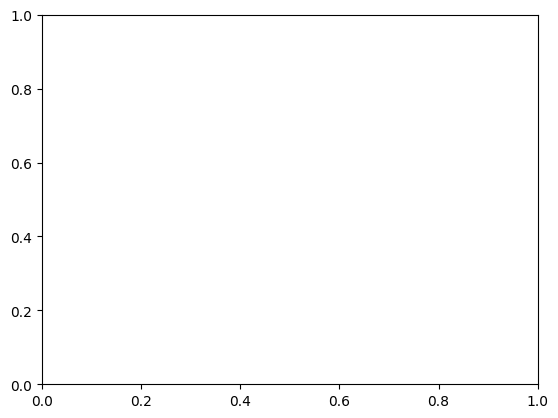

In [15]:

plt.plot(train_loss, label='Training_loss')
plt.plot(test_loss, label='Validation_loss')
plt.title('Loss at epoch')
plt.legend()

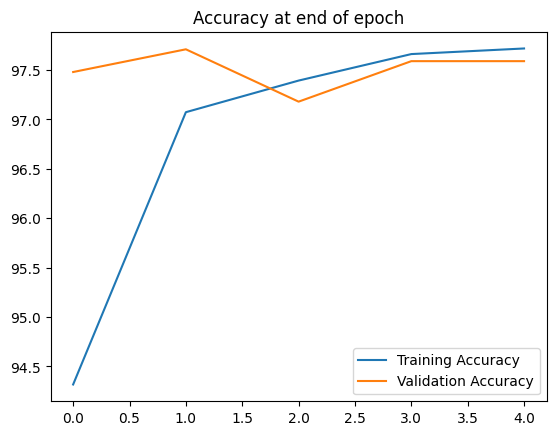

In [16]:
plt.plot([t/600 for t in train_correct], label = 'Training Accuracy')
plt.plot([t/100 for t in test_correct], label = 'Validation Accuracy')
plt.title('Accuracy at end of epoch')
plt.legend()

In [17]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle= False)
correct = 0
for x_test, y_test in test_load_everything:
  y_val = model(x_test)
  predicted = torch.max(y_val,1)[1]
  correct += (predicted == y_test).sum()


In [44]:
correct.item()/len(test_data)*100

98.06

In [19]:
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [20]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

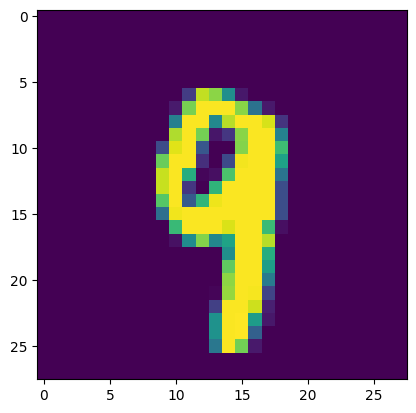

In [21]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [22]:
model.eval()
with torch.no_grad():
  new_pred = model(test_data[4143][0].view(1,1,28,28)) # 1st 1 = batch size



In [23]:
new_pred

tensor([[-1.2241e+01, -1.4152e+01, -1.3572e+01, -1.0018e+01, -7.1440e+00,
         -1.3571e+01, -2.9900e+01, -9.5907e+00, -1.1821e+01, -9.1844e-04]])

In [24]:
new_pred.argmax()

tensor(9)